In [114]:
# For some reason Theano is unhappy when I run the GP, need to disable future warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import os
import sys
import requests
import pymc3 as pm
from pymc3 import Model, sample, Normal, HalfCauchy, Uniform, model_to_graphviz
import pandas as pd
import numpy as np
import theano
import theano.tensor as tt
from sklearn.preprocessing import StandardScaler

from matplotlib import pyplot as plt
from matplotlib import dates as mdates
from matplotlib import ticker

from datetime import date
from datetime import datetime

from IPython.display import clear_output

%config InlineBackend.figure_format = 'retina'

In [71]:
SCRIPT_PATH='.'
module_path = os.path.abspath(os.path.join(SCRIPT_PATH))
if module_path not in sys.path:
    sys.path.append(module_path)

In [72]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [73]:
from utils import load_county_case_data, load_patient_data, get_delay_onset_confirmation_probabilities
from utils import prepare_county_cases, adjust_onset_for_right_censorship, confirmed_to_onset
from utils import create_and_run_model_for_counties, df_from_model, reparametrize
from utils import agg_cases_to_state_level, aggregate_results, plot_rt, prepare_cases, load_daily_state_cases
from utils import compute_mean_kinsa_atypical_illness, compute_delay_onset_confirmation_probabilities, compute_adjusted_cases

In [74]:
kinsa = pd.read_csv("data/kinsa.csv")
kinsa.drop(["Unnamed: 0", "region_type", "observed_ili"], axis=1, inplace=True)
kinsa.dropna(inplace=True)

In [75]:
kinsa.head()

,region_id,region_name,state,date,doy,atypical_ili,atypical_ili_delta,anomaly_fevers,forecast_expected,forecast_lower,forecast_upper
1288,1021,Chilton County,AL,2020-03-06,66,3.953519,0.020049,4.910440,2.882840,1.832210,3.933470
1292,1097,Mobile County,AL,2020-03-06,66,5.020032,0.000890,1.802003,3.993658,2.968173,5.019142
1345,1043,Cullman County,AL,2020-03-07,67,4.567976,0.247477,67.605764,3.217172,2.113845,4.320499
1362,1117,Shelby County,AL,2020-03-07,67,4.252232,0.124317,356.004828,3.015529,1.903143,4.127914
1375,1103,Morgan County,AL,2020-03-07,67,4.482549,0.043693,64.825846,3.316540,2.194224,4.438856


In [76]:
states = load_daily_state_cases()

Not all states have updated
state
AK   2020-05-27
AL   2020-05-27
AR   2020-05-27
AZ   2020-05-27
CA   2020-05-27
CO   2020-05-27
CT   2020-05-27
DC   2020-05-27
DE   2020-05-27
FL   2020-05-27
GA   2020-05-27
HI   2020-05-27
IA   2020-05-27
ID   2020-05-27
IL   2020-05-27
IN   2020-05-27
KS   2020-05-27
KY   2020-05-27
LA   2020-05-27
MA   2020-05-27
MD   2020-05-27
ME   2020-05-27
MI   2020-05-27
MN   2020-05-27
MO   2020-05-27
MS   2020-05-27
MT   2020-05-27
NC   2020-05-27
ND   2020-05-27
NE   2020-05-27
NH   2020-05-27
NJ   2020-05-27
NM   2020-05-27
NV   2020-05-27
NY   2020-05-27
OH   2020-05-27
OK   2020-05-27
OR   2020-05-27
PA   2020-05-27
RI   2020-05-27
SC   2020-05-27
SD   2020-05-27
TN   2020-05-27
TX   2020-05-27
UT   2020-05-27
VA   2020-05-27
VT   2020-05-27
WA   2020-05-27
WI   2020-05-27
WV   2020-05-27
WY   2020-05-27
Name: date, dtype: datetime64[ns]
state  date      
CO     2020-05-12   -20.0
Name: positive, dtype: float64
state  date      
HI     2020-05-15   -1.

In [116]:
p_delays = compute_delay_onset_confirmation_probabilities()

In [78]:
def plot(state, state_cases, kinsa_state_cases):
    figure, ax1 = plt.subplots(figsize=(9, 6))
    ax2 = ax1.twinx()
    ax1.plot(kinsa_state_cases.index, kinsa_state_cases["atypical_ili"], lw=3, color="crimson", label="Kinsa")
    ax2.plot(state_cases.index, state_cases.values, lw=3, color="purple", label="NewCases")
    plt.xticks(fontsize=18)
    plt.yticks(fontsize=18)
    ax1.set_ylabel("Kinsa atypical illness", fontsize=18, labelpad=10)
    ax2.set_ylabel("New Cases", fontsize=18, labelpad=10)
    ax1.tick_params(axis='x', labelsize= 18)
    ax1.xaxis.set_major_formatter(mdates.DateFormatter('%m/%d'))
    ax1.xaxis.set_major_locator(mdates.WeekdayLocator(interval=1))
    figure.autofmt_xdate()
    plt.title(state, fontsize=20)
    plt.gcf().subplots_adjust(bottom=0.3)
    plt.gcf().subplots_adjust(left=0.3)
    figure.tight_layout(pad=3.0);    
    plt.savefig("reports/kinsa_" + state + ".pdf", bbox_inches="tight")
    plt.show()
    plt.close()   

/Users/gryv9001/miniconda3/envs/dsai37/lib/python3.7/site-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


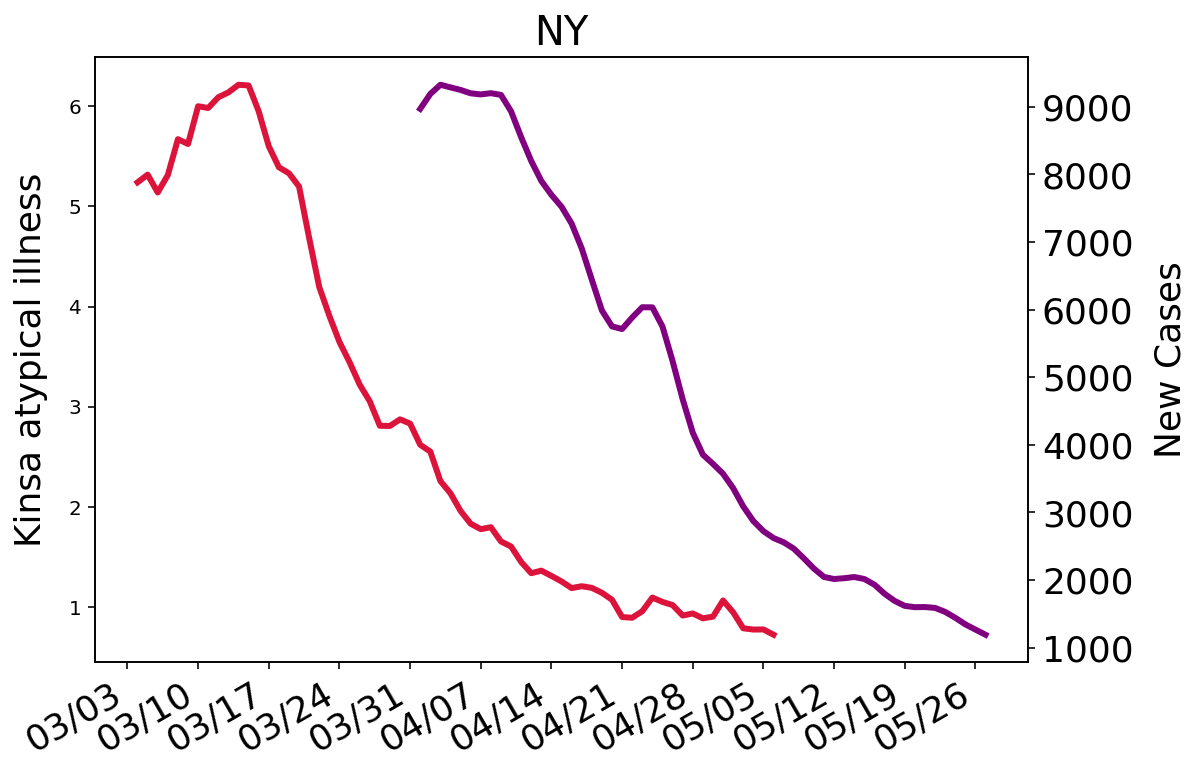

In [79]:
state = "NY"
smoothed_state_cases, _ = compute_adjusted_cases(state, states, p_delays)
mean_kinsa = compute_mean_kinsa_atypical_illness(kinsa, state)
plot(state, smoothed_state_cases, mean_kinsa)

/Users/gryv9001/miniconda3/envs/dsai37/lib/python3.7/site-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


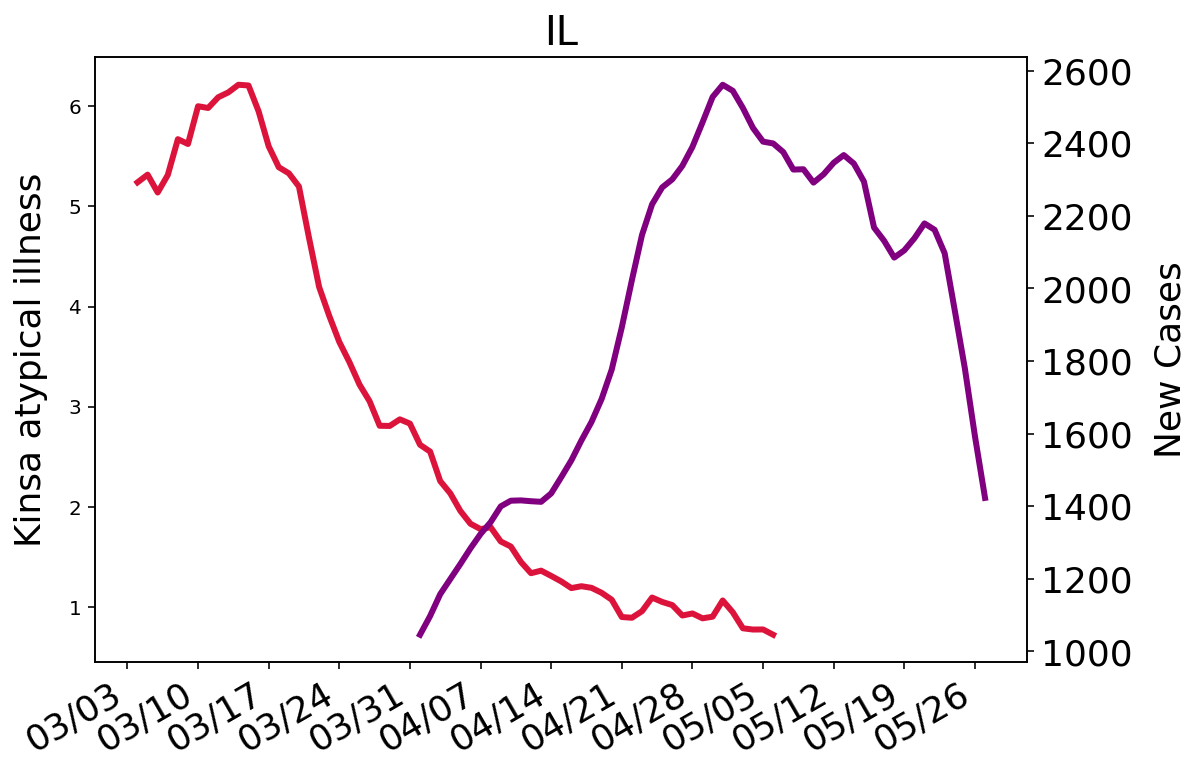

In [80]:
state = "IL"
smoothed_state_cases, _ = compute_adjusted_cases(state, states, p_delays)
mean_ny_kinsa = compute_mean_kinsa_atypical_illness(kinsa, state)
plot(state, smoothed_state_cases, mean_kinsa)

/Users/gryv9001/miniconda3/envs/dsai37/lib/python3.7/site-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


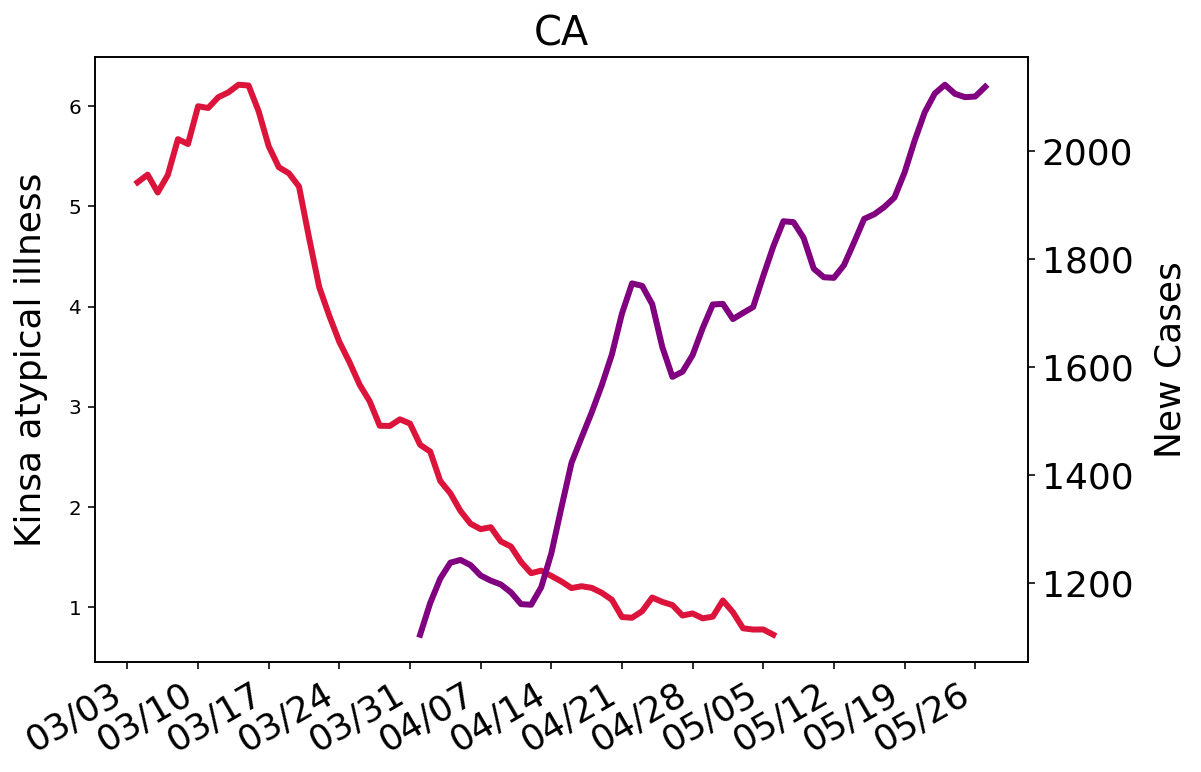

In [81]:
state = "CA"
smoothed_state_cases, _ = compute_adjusted_cases(state, states, p_delays)
mean_ny_kinsa = compute_mean_kinsa_atypical_illness(kinsa, state)
plot(state, smoothed_state_cases, mean_kinsa)

/Users/gryv9001/miniconda3/envs/dsai37/lib/python3.7/site-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


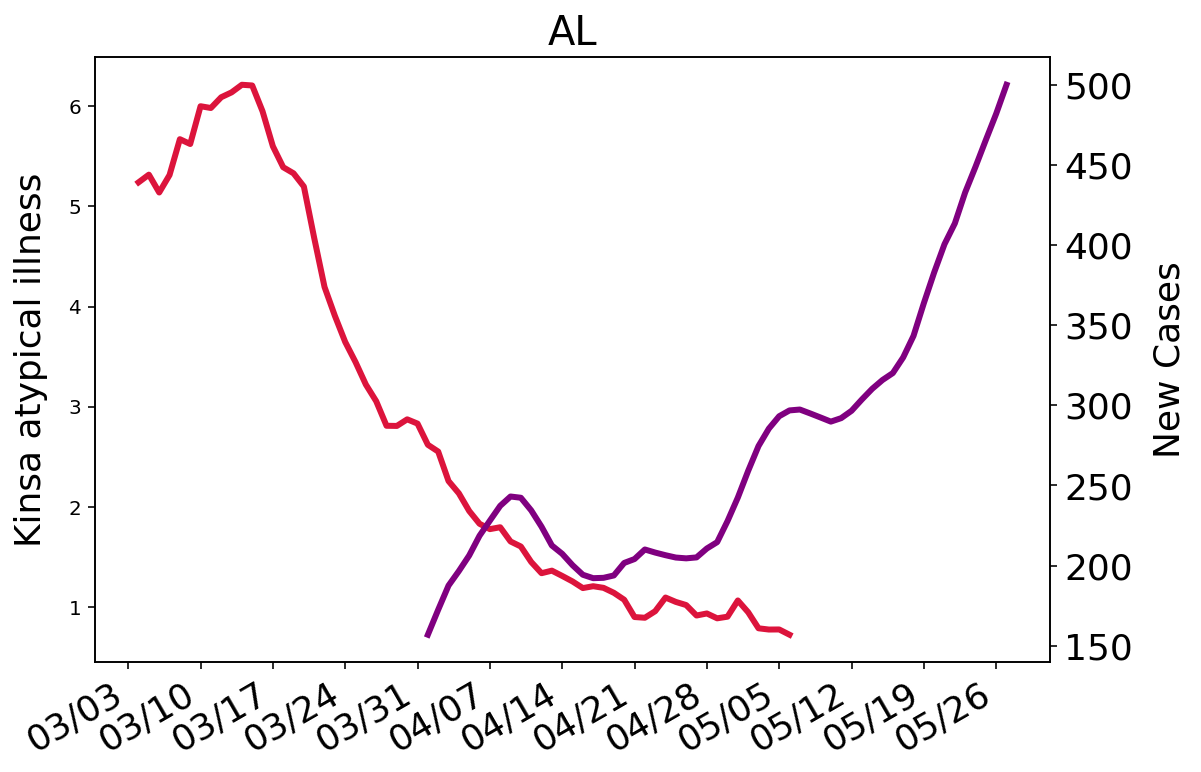

In [82]:
state = "AL"
smoothed_state_cases, _ = compute_adjusted_cases(state, states, p_delays)
mean_ny_kinsa = compute_mean_kinsa_atypical_illness(kinsa, state)
plot(state, smoothed_state_cases, mean_kinsa)

/Users/gryv9001/miniconda3/envs/dsai37/lib/python3.7/site-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


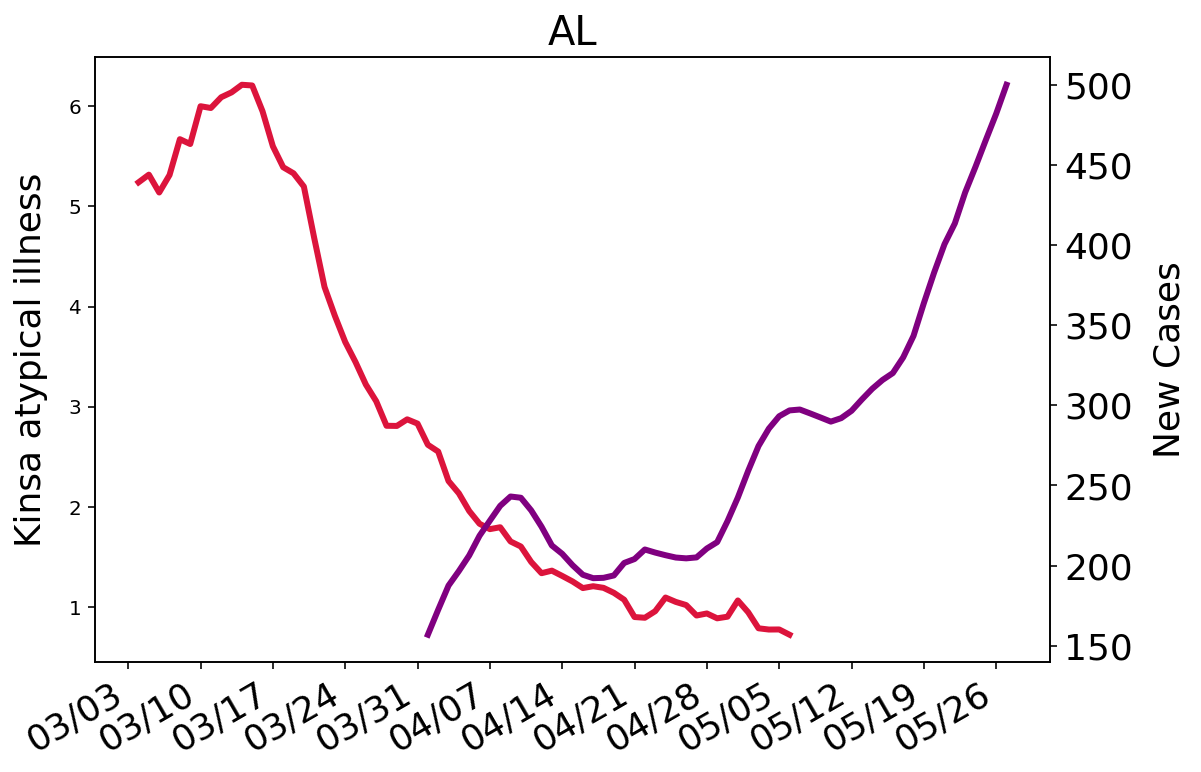

In [83]:
state = "AL"
smoothed_state_cases, _ = compute_adjusted_cases(state, states, p_delays)
mean_ny_kinsa = compute_mean_kinsa_atypical_illness(kinsa, state)
plot(state, smoothed_state_cases, mean_kinsa)